In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
import os
from tqdm import tqdm

In [5]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [6]:
PATH = Path('../data/')

In [7]:
! ls {PATH}/camvid

codes.txt  images  labels  valid.txt


In [8]:
path_img = PATH/'camvid/images'
path_label = PATH/'camvid/labels'

# Dataset

In [9]:
fnames = get_image_files(path_img)
print(fnames[:3])

[PosixPath('../data/camvid/images/0016E5_05910.png'), PosixPath('../data/camvid/images/Seq05VD_f02370.png'), PosixPath('../data/camvid/images/0001TP_007140.png')]


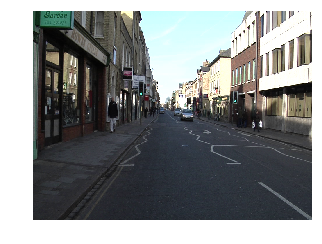

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: path_label/f'{x.stem}_P{x.suffix}'

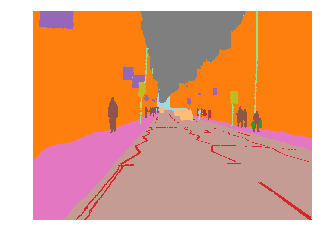

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 5994MB of GPU RAM free


In [14]:
codes = np.loadtxt(PATH/'camvid/codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid
# metrics=accuracy

In [19]:
wd=1e-2

In [29]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


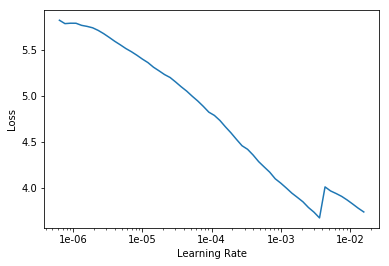

In [20]:
lr_find(learn)
learn.recorder.plot()

In [22]:
lr=3e-3

In [23]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,0.952294,0.698198,0.827493
2,0.693250,0.528644,0.853439
3,0.689616,0.542785,0.863898
4,0.611938,0.470305,0.877587
5,0.585304,0.780716,0.818112
6,0.604943,0.518795,0.868369
7,0.548149,0.456748,0.888232
8,0.515432,0.421034,0.883500
9,0.520012,0.424857,0.878286
10,0.429525,0.321824,0.905464


In [24]:
learn.save('stage-1')

In [27]:
learn.load('stage-1');

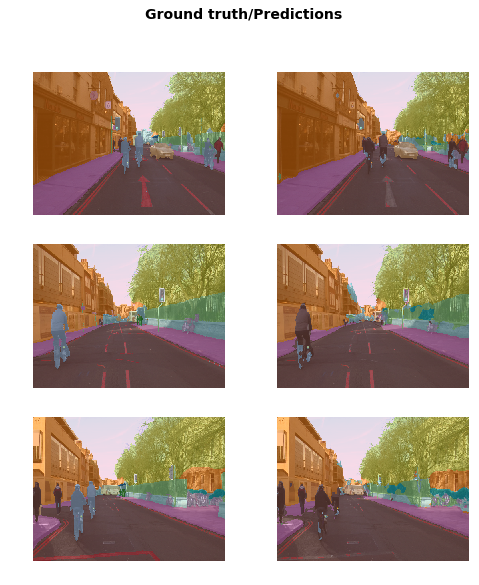

In [25]:
learn.show_results(rows=3, figsize=(8,9))

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/400,lr/4)

In [33]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.367886,0.312310,0.910642
2,0.363187,0.305476,0.912942
3,0.359926,0.300516,0.915927
4,0.363143,0.316373,0.908797
5,0.337316,0.306621,0.914281
6,0.334795,0.302418,0.914168
7,0.340476,0.295476,0.918104
8,0.342658,0.294713,0.917201
9,0.320414,0.279523,0.924870
10,0.312724,0.287288,0.919860


In [34]:
learn.save('stage-2');

# Go bigger

In [22]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 5994MB of GPU RAM free


In [23]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [25]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


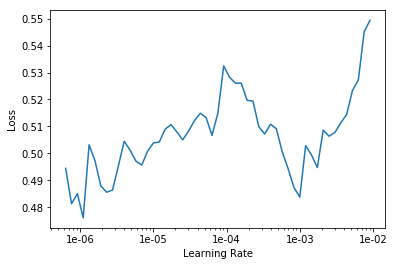

In [26]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lr=1e-3

In [28]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.407796,0.339348,0.909233
2,0.374202,0.354902,0.906266
3,0.351195,0.326212,0.911526
4,0.351125,0.305553,0.910756
5,0.326603,0.350248,0.913078
6,0.356395,0.337981,0.908183
7,0.328927,0.294141,0.919774
8,0.313659,0.284757,0.916769
9,0.287228,0.275817,0.923846
10,0.256942,0.249089,0.930641


In [29]:
learn.save('stage-1-big')

In [30]:
learn.load('stage-1-big');

In [31]:
learn.unfreeze()

In [32]:
lrs = slice(1e-6,lr/10)

In [33]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.228336,0.248129,0.931688
2,0.236961,0.252271,0.931176
3,0.231725,0.253858,0.932306
4,0.221202,0.252281,0.932888
5,0.221258,0.249605,0.932793
6,0.217072,0.247320,0.934123
7,0.213651,0.252532,0.934805
8,0.213273,0.243880,0.935649
9,0.212921,0.255567,0.933009
10,0.204688,0.255518,0.933246


In [34]:
learn.save('stage-2-big')

In [25]:
learn.load('stage-2-big');

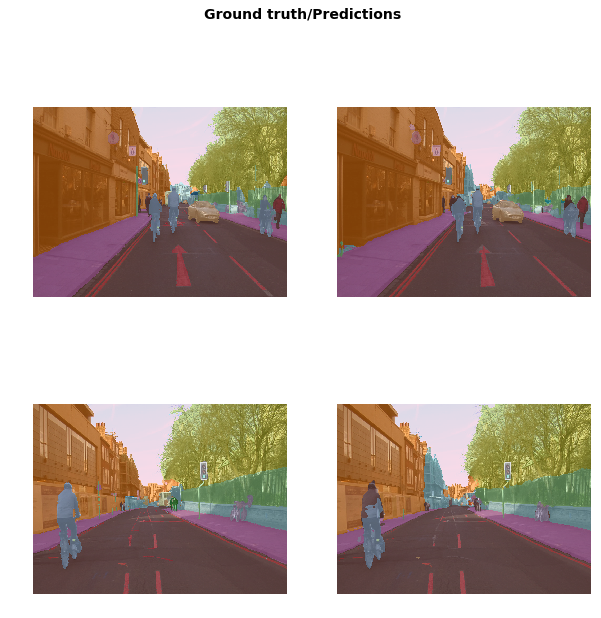

In [29]:
learn.show_results(rows=3, figsize=(10,10))

In [37]:
learn.export()